In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Tropical cyclones only (full exploratory analysis)

## Load data

In [2]:
project_dir = Path().resolve().parents[2]

In [3]:
df_tce = pd.read_csv(project_dir.joinpath('data/TCE-DAT_historic-exposure_1950-2015_cl_distances.csv'))
df_emdat = pd.read_excel(project_dir.joinpath('data/em_dat.xlsx'), header=6)
df_emdat.columns = df_emdat.columns.str.replace(' ', '')
df_emdat = df_emdat.rename(columns={'TotalDamages(\'000US$)': 'TotalDamages'})

In [4]:
df_tce.head()

,year,IBTrACS_ID,TC_name,NatCatSERVICE_ID,genesis_basin,countries_affected,ISO3,v_land_SI,v_land_kn,pop_34kn,...,pop_96kn_15km,assets_34kn_15km,assets_64kn_15km,assets_96kn_15km,pop_34kn_30km,pop_64kn_30km,pop_96kn_30km,assets_34kn_30km,assets_64kn_30km,assets_96kn_30km
0,1950,1950166N14262,UNNAMED,NaN,EP,single,MEX,47.3,92.0,1.435042e+06,...,0.000000,1.814476e+09,4.357072e+08,0.000000e+00,7.637151e+05,142266.342695,0.000000,2.760891e+09,5.392150e+08,0.000000e+00
1,1950,1950174N17126,ELSIE,NaN,WP,multi,JPN,51.7,100.6,8.460128e+06,...,19704.633461,5.334348e+10,7.370407e+09,2.335967e+08,8.230620e+06,777936.359565,19704.633461,6.854200e+10,7.370407e+09,2.335967e+08
2,1950,1950174N17126,ELSIE,NaN,WP,multi,KOR,19.5,37.8,4.054694e+05,...,0.000000,8.689325e+08,0.000000e+00,0.000000e+00,4.054694e+05,0.000000,0.000000,8.689325e+08,0.000000e+00,0.000000e+00
3,1950,1950185N18254,UNNAMED,NaN,EP,single,MEX,28.8,55.9,1.943859e+05,...,0.000000,4.938643e+08,0.000000e+00,0.000000e+00,1.681960e+05,0.000000,0.000000,6.512574e+08,0.000000e+00,0.000000e+00
4,1950,1950191N12149,UNNAMED,NaN,WP,single,JPN,26.0,50.5,1.495236e+05,...,0.000000,1.206838e+09,0.000000e+00,0.000000e+00,1.350129e+05,0.000000,0.000000,1.647435e+09,0.000000e+00,0.000000e+00


In [5]:
df_emdat = df_emdat[(df_emdat.Year >= 1980) & (df_emdat.DisasterSubtype == 'Tropical cyclone')]

In [6]:
df_emdat.count()

DisNo                           1776
Year                            1776
Seq                             1776
DisasterGroup                   1776
DisasterSubgroup                1776
DisasterType                    1776
DisasterSubtype                 1776
DisasterSubsubtype                 0
EventName                       1633
EntryCriteria                   1776
Country                         1776
ISO                             1776
Region                          1776
Continent                       1776
Location                        1550
Origin                             9
AssociatedDis                    661
AssociatedDis2                   253
OFDAResponse                     213
Appeal                           269
Declaration                      366
AidContribution                  116
DisMagValue                      710
DisMagScale                     1776
Latitude                         101
Longitude                        102
LocalTime                          4
R

## Match TCE-DAT events to EM-DAT data when possible

In [7]:
df_tce['start_date'] = pd.to_datetime(df_tce.IBTrACS_ID.str.slice(0, 7), format='%Y%j')
df_tce['year'] = df_tce.start_date.dt.year
df_tce['month'] = df_tce.start_date.dt.month
df_tce['day'] = df_tce.start_date.dt.day
df_tce = df_tce.rename(columns={'ISO3': 'ISO'})

In [8]:
df_emdat = df_emdat.dropna(subset=['StartDay']).rename(columns={'StartYear':'year', 'StartMonth':'month', 'StartDay':'day'})
df_emdat['start_date'] = pd.to_datetime(df_emdat[['year', 'month', 'day']])

In [9]:
df_tce.start_date.min(), df_tce.start_date.max()

(Timestamp('1950-06-15 00:00:00'), Timestamp('2015-12-21 00:00:00'))

In [10]:
df_emdat.start_date.min(), df_emdat.start_date.max()

(Timestamp('1980-01-27 00:00:00'), Timestamp('2020-06-07 00:00:00'))

In [11]:
df_tce = df_tce[df_tce.start_date.dt.year >= 1980]
df_emdat = df_emdat[df_emdat.start_date.dt.year <= 2015]
len(df_tce), len(df_emdat)

(3118, 1483)

### Using start dates

First, check if (start_date, country) can uniquely identify storms.

The start date for IBTrACS data is derived from its ibtracs id, which is based on "the first recorded observation of the storm" (https://www.ncdc.noaa.gov/ibtracs/index.php?name=sid).
Format is YYYYJJJHTTNNN, with
- YYYY is the corresponding year of the first recorded observation of the storm
- JJJ is the day of year of the first recorded observation of the storm
- H is the hemisphere of the storm: N=Northern, S=Southern
- TT is the absolute value of the rounded latitude of the first recorded observation of the storm (range 0-90, if basin=SA or SH, then TT in reality is negative)
- NNN is the rounded longitude of the first recorded observation of the storm (range 0-359)

No details regarding EM-DAT start date

It seems not : for 2 cases in EM-DAT (and 50 in IBTrACS), different cyclones hitting the same country were born the same day.

In [12]:
df_emdat[df_emdat[['start_date', 'ISO']].duplicated(keep=False)]

,DisNo,Year,Seq,DisasterGroup,DisasterSubgroup,DisasterType,DisasterSubtype,DisasterSubsubtype,EventName,EntryCriteria,...,TotalDeaths,NoInjured,NoAffected,NoHomeless,TotalAffected,ReconstructionCosts('000US$),InsuredDamages('000US$),TotalDamages,CPI,start_date
16777,2007-0463-PHL,2007,463,Natural,Meteorological,Storm,Tropical cyclone,NaN,Lekima,Kill,...,8.0,NaN,2000.0,NaN,2000.0,NaN,NaN,NaN,81.101659,2007-09-29
16780,2007-0667-PHL,2007,667,Natural,Meteorological,Storm,Tropical cyclone,NaN,Hanna,Kill,...,11.0,NaN,12515.0,NaN,12515.0,NaN,NaN,260.0,81.101659,2007-09-29
19575,2012-0260-CHN,2012,260,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical storm Gener (Saola),Kill,...,34.0,NaN,183630.0,48540.0,232170.0,NaN,NaN,124000.0,89.805293,2012-08-08
19712,2012-0282-CHN,2012,282,Natural,Meteorological,Storm,Tropical cyclone,NaN,Typhoon Haikui,Affected,...,3.0,7.0,6000000.0,NaN,6000007.0,NaN,230000.0,1500000.0,89.805293,2012-08-08


In [13]:
df_tce[df_tce[['start_date', 'ISO']].duplicated(keep=False)].shape

(50, 36)

Try to merge anyway: only 75 events match the start date exactly and the country. At least, it seems in a number of cases, the names do match.

Here are a few cases where the names do not match:
- 1983321N11111 PERCY / Orchid (Warling). According to https://en.wikipedia.org/wiki/1983_Pacific_typhoon_season#Typhoon_Percy_(Yayang), the 2 storms actually merged
- 1990232N13141 BECKY / Yancy. It seems these are 2 different storms (https://en.wikipedia.org/wiki/1990_Pacific_typhoon_season), that appear to have the same start date in EM-DAT and ibtracs
- 1989268N14261 RAYMOND / Hugo : these are 2 different storms that have same dates in EM-DAT/Ibtracs (https://en.wikipedia.org/wiki/Hurricane_Hugo, https://en.wikipedia.org/wiki/Hurricane_Raymond_(1989))

It seems relying only on the exact start date is not reliable at all (and does not give many matches anyway)

In [14]:
df_emdat.merge(df_tce, on=['start_date', 'ISO'])[['IBTrACS_ID', 'ISO', 'start_date', 'EventName', 'TC_name']]

,IBTrACS_ID,ISO,start_date,EventName,TC_name
0,1982154N22273,CUB,1982-06-03,Alberto,ALBERTO
1,1983010S08049,COM,1983-01-10,Elinah,ELINAH
2,1984260N14339,CPV,1984-09-16,Fran,FRAN
3,1986313N22089,BGD,1986-11-09,NaN,UNNAMED
4,1980201N08155,PHL,1980-07-19,(Nitang/Osang),UNNAMED
...,...,...,...,...,...
70,2014068S16169,VUT,2014-03-09,Tropical cylone Lusi,LUSI
71,2014253N14260,MEX,2014-09-10,Hurricane Odile,ODILE
72,2014245N19268,MEX,2014-09-02,Hurricane Norbert,DOLLY
73,2014260N13135,PHL,2014-09-17,Tropical strom Fung-Wong (Mario),FUNG-WONG


### Using the event's name

#### Inner merge

In [15]:
len(df_emdat), df_emdat['EventName'].count()

(1483, 1355)

Most recent EM-DAT events have a name: we can try using it to match with IBTrACS

In [16]:
# Merge on country, year
df = df_emdat.merge(df_tce, on=['ISO', 'year'], suffixes=('', '_tce'))
df.EventName = df.EventName.astype('str') # remove NaN values
df[['ISO', 'year', 'EventName', 'TC_name']]

,ISO,year,EventName,TC_name
0,BRB,1980,Allen,ALLEN
1,CHN,1980,Joe,GEORGIA
2,CHN,1980,Joe,HERBERT
3,CHN,1980,Joe,UNNAMED
4,CHN,1980,Joe,UNNAMED
...,...,...,...,...
5914,VNM,2015,Tropical storm Kujira,VAMCO
5915,VNM,2015,Tropical storm Kujira,MUJIGAE
5916,VNM,2015,Cyclone Vamco,KUJIRA
5917,VNM,2015,Cyclone Vamco,VAMCO


In [17]:
# Filter rows where ibtracs name is in the em-dat event name: in addition to country/year matching, the names match too.
match = df.apply(lambda x: x.TC_name.casefold() in x.EventName.casefold(), axis=1)
df_merged_inner = df[match]

We are able to match around 900 events, but there might be some duplicates (country/years where multiple ibtracs TC names match the same EM-DAT event).

In [18]:
df_merged_inner[['ISO', 'year', 'EventName', 'TC_name']]

,ISO,year,EventName,TC_name
0,BRB,1980,Allen,ALLEN
9,CUB,1980,Allen,ALLEN
11,DMA,1980,Allen,ALLEN
12,DOM,1980,Allen,ALLEN
14,GRD,1980,Allen,ALLEN
...,...,...,...,...
5908,VUT,2015,Cyclone 'Pam',PAM
5910,YEM,2015,Cyclone Megh,MEGH
5911,YEM,2015,Cyclone Chapala,CHAPALA
5913,VNM,2015,Tropical storm Kujira,KUJIRA


In [19]:
# Here are the duplicates (multiple cyclones considered as a single event in EM-DAT)
df_merged_inner.loc[df_merged_inner.DisNo.duplicated(keep=False), ['ISO', 'year', 'EventName', 'DisNo', 'TC_name']]

,ISO,year,EventName,DisNo,TC_name
72,FJI,1985,"Eric, Nigel, Odette",1985-0021-FJI,ERIC
73,FJI,1985,"Eric, Nigel, Odette",1985-0021-FJI,NIGEL
352,MDG,1982,"Benedic, Electre, Frida, Justine",1982-0147-MDG,ELECTRE
353,MDG,1982,"Benedic, Electre, Frida, Justine",1982-0147-MDG,FRIDA
354,MDG,1982,"Benedic, Electre, Frida, Justine",1982-0147-MDG,JUSTINE
596,PHL,1986,Wayne (Miding),1986-0104-PHL,WAYNE
597,PHL,1986,Wayne (Miding),1986-0104-PHL,WAYNE
781,PHL,1988,Tess (Welpring),1988-0557-PHL,TESS
782,PHL,1988,Tess (Welpring),1988-0557-PHL,TESS
852,VUT,1985,Eric & Nigel,1985-0020-VUT,ERIC


In [20]:
# TODO: add the indicators together (nb ppl concerned)? Or take the max? 
# Probably depends on how TCE-DAT was built, i.e considering all TCs during their life (even spurs), or considering only main tracks (and spurs until they merge)
# For now simply take the first
df_merged_inner = df_merged_inner.drop_duplicates(subset='DisNo')

In [21]:
# Create exclusive bins (34kn - 64kn, 64kn - 96kn, 96+, instead of 34+, 64+, 96+)
for exposed in ['pop', 'assets']:
    df_merged_inner[f'{exposed}34'] = df_merged_inner[f'{exposed}_34kn'] - df_merged_inner[f'{exposed}_64kn']
    df_merged_inner[f'{exposed}64'] = df_merged_inner[f'{exposed}_64kn'] - df_merged_inner[f'{exposed}_96kn']
    df_merged_inner[f'{exposed}96'] = df_merged_inner[f'{exposed}_96kn']
    
    # Same for pop/assets below a certain distance from the coastline
    for d in [5, 15, 30]:
        df_merged_inner[f'{exposed}34_d{d}'] = df_merged_inner[f'{exposed}_34kn_{d}km'] - df_merged_inner[f'{exposed}_64kn_{d}km']
        df_merged_inner[f'{exposed}64_d{d}'] = df_merged_inner[f'{exposed}_64kn_{d}km'] - df_merged_inner[f'{exposed}_96kn_{d}km']
        df_merged_inner[f'{exposed}96_d{d}'] = df_merged_inner[f'{exposed}_96kn_{d}km']

#### Data that wasn't merged

In [22]:
df_merged = df_emdat.merge(df_merged_inner, on=df_emdat.columns.tolist(), how='outer')
df_merged.head()

,DisNo,Year,Seq,DisasterGroup,DisasterSubgroup,DisasterType,DisasterSubtype,DisasterSubsubtype,EventName,EntryCriteria,...,assets96,assets34_d5,assets64_d5,assets96_d5,assets34_d15,assets64_d15,assets96_d15,assets34_d30,assets64_d30,assets96_d30
0,1980-0306-BRB,1980,306,Natural,Meteorological,Storm,Tropical cyclone,NaN,Allen,Affect,...,2.317466e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1980-0069-CHN,1980,69,Natural,Meteorological,Storm,Tropical cyclone,NaN,Joe,Kill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1980-0229-CUB,1980,229,Natural,Meteorological,Storm,Tropical cyclone,NaN,Allen,Declar,...,1.397305e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1980-0230-DMA,1980,230,Natural,Meteorological,Storm,Tropical cyclone,NaN,Allen,Declar,...,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1980-0231-DOM,1980,231,Natural,Meteorological,Storm,Tropical cyclone,NaN,Allen,SigDam,...,0.000000e+00,4.636325e+08,0.0,0.0,1.382533e+09,0.0,0.0,2.510018e+09,0.0,0.0


In [23]:
df_merged.loc[df_merged.v_land_kn.isna(), ['DisNo', 'ISO', 'year', 'EventName', 'TC_name', 'TotalDeaths', 'TotalAffected', 'TotalDamages']].describe()

,year,TotalDeaths,TotalAffected,TotalDamages
count,607.000000,452.000000,4.660000e+02,3.000000e+02
mean,1998.051071,434.559735,3.628754e+05,1.821712e+05
std,9.920760,6582.993864,1.352540e+06,5.541905e+05
min,1980.000000,1.000000,3.000000e+00,5.000000e+00
25%,1990.000000,4.000000,1.238000e+03,2.000000e+03
50%,1999.000000,12.000000,1.132600e+04,1.300000e+04
75%,2006.000000,46.250000,1.003210e+05,1.125000e+05
max,2015.000000,138866.000000,1.543885e+07,6.000000e+06


In [24]:
df_merged.loc[~df_merged.v_land_kn.isna(), ['DisNo', 'ISO', 'year', 'EventName', 'TC_name', 'TotalDeaths', 'TotalAffected', 'TotalDamages']].describe()

,year,TotalDeaths,TotalAffected,TotalDamages
count,876.000000,711.000000,6.980000e+02,6.060000e+02
mean,2001.380137,315.872011,6.876111e+05,1.044036e+06
std,9.447262,5234.142662,2.248829e+06,5.947305e+06
min,1980.000000,1.000000,2.000000e+00,1.000000e+01
25%,1994.000000,4.000000,2.820750e+03,1.800000e+04
50%,2004.000000,14.000000,2.751050e+04,8.500000e+04
75%,2009.000000,47.000000,2.730350e+05,4.498500e+05
max,2015.000000,138366.000000,2.962200e+07,1.250000e+08


In [25]:
df_merged['is_match'] = ~df_merged.v_land_kn.isna()

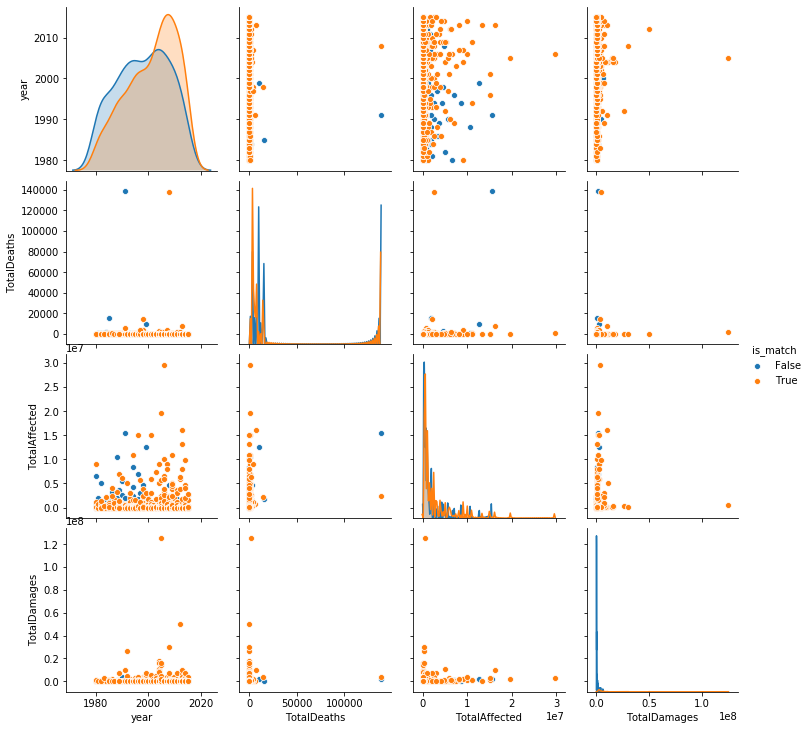

In [26]:
sns.pairplot(df_merged[['is_match', 'ISO', 'year', 'EventName', 'TC_name', 'TotalDeaths', 'TotalAffected', 'TotalDamages']], hue='is_match')

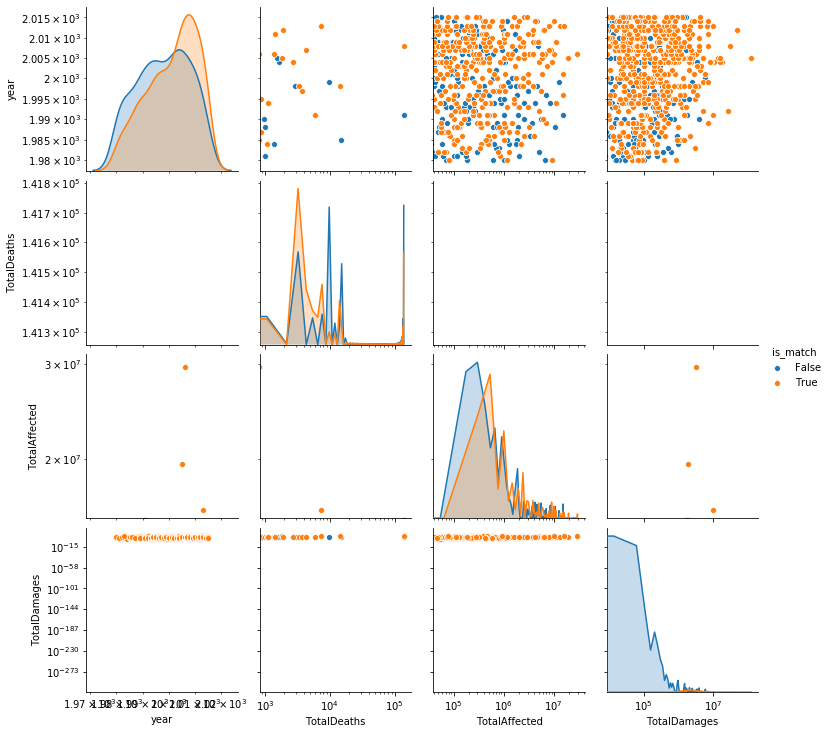

In [27]:
g = sns.pairplot(df_merged[['is_match', 'ISO', 'year', 'EventName', 'TC_name', 'TotalDeaths', 'TotalAffected', 'TotalDamages']], hue='is_match')
g.set(yscale='log')
g.set(xscale='log')
plt.show()

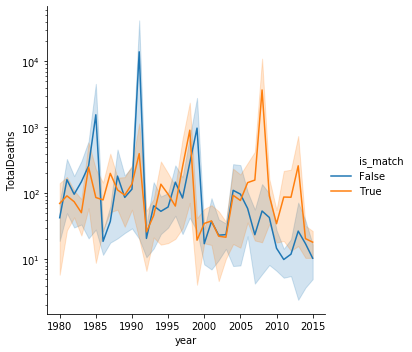

In [28]:
g = sns.relplot(x='year', y='TotalDeaths', hue='is_match', kind='line', data=df_merged)
g.set(yscale='log')
plt.show()

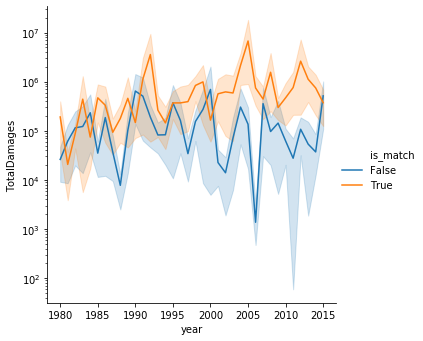

In [29]:
g = sns.relplot(x='year', y='TotalDamages', hue='is_match', kind='line', data=df_merged)
g.set(yscale='log')
plt.show()

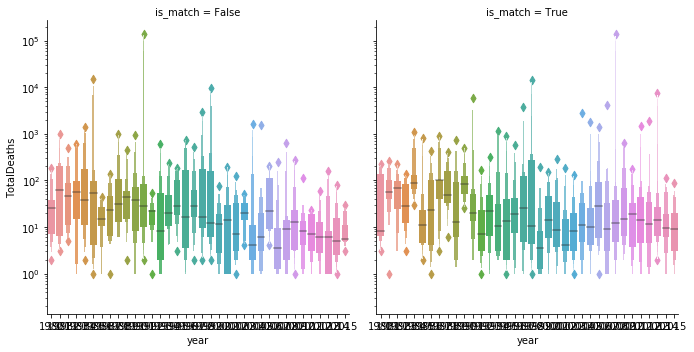

In [30]:
g = sns.catplot(x='year', y='TotalDeaths', col='is_match', kind='boxen', data=df_merged)
g.set(yscale='log')
plt.show()

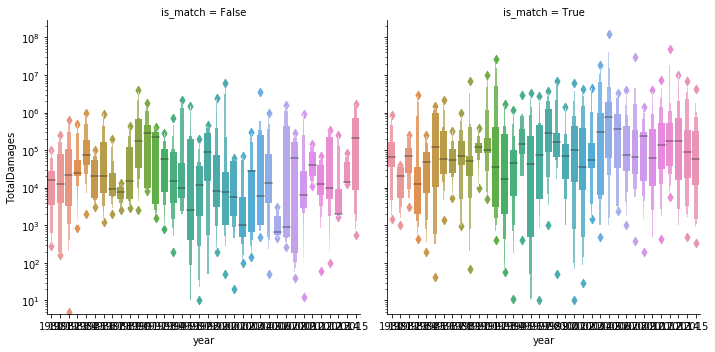

In [31]:
g = sns.catplot(x='year', y='TotalDamages', col='is_match', kind='boxen', data=df_merged)
g.set(yscale='log')
plt.show()

In [32]:
df_merged.to_excel(project_dir.joinpath('data/emdat_tcedat_merged.xlsx'), index=False)

In [33]:
#df_tce.to_excel(project_dir.joinpath('data/tcedat_tmp.xlsx'))

In [34]:
df_merged.is_match.value_counts()

True     876
False    607
Name: is_match, dtype: int64

Let's have a look manually at a few exemples where there was no match.

First, 128 entries (out of 1483) in EM-DAT have no event name (more frequent for older data).

- 1980197N07154, Typhoon Joe hit a few countries. TC_name is UNNAMED in TCE-DAT, but Joe in a number of cases in EM-DAT. By looking at the file name of ibtracs, we find the name JOE, which would have allowed to match for the storm hitting China, Vietnam, and Philippines (although double entry for Philippines in EM-DAT??). HKG is not recorded as a hit in TCE-DAT, although there are casualties reccorded by EM-DAT
- 1981176N08150, Typhoon Kelly hit the Philippines and Thailand (double entry again for Philippines??). Name KELLY is in TCE-DAT database, for countries that have been hit, but entries in EM-DAT seem to be missing (no entries for China or HK) or have a different name (Daling) for PHL. Name (Daling) is not present in the ibtracs names file.
- 2007050S16079, Cyclone Gamede is in EM-DAT but not in the TCE-DAT database, probably because it came close to la Réunion, bringing rain & flood without making landfall
- 2013130N04093, Storm Mahasen is matched in EMDAT/TCE-DAT for most countries (india, bangladesh), but not for Sri Lanka, as the casualties were caused by heavy rains even though the storm was too far to be responsible for it.
- 2015237N14315, TC Erika made a lot of damage in the Dominican republic, and has an EM-DAT entry. But no TCE-DAt entry, because ibtracs data stops before making landfall in the Dominican Republic, as the storm weakens.
- 2015270N27291, Hurricane Joaquin hit the Bahamas (and was correctly matched). There is an entry for the US in EM-DAT, but not in TCE-DAT, as the storm was far from the US, but another storm system closer to the US drew humidity from Joaquin and caused floods in the US

It seems that the main reasons for EM-DAT data not matching are:
- The storm did not make a direct landfall and is not in the TCE-DAT data, but still made damages (rain and floods)
- The storm has no recorded name in EM-DAT (128 cases) 
- The names of the storm in EM-DAT does not match the name in TCE-DAT (differences in agency notations, or storm recorded as UNNAMED in TCE-DAT). In some cases, by looking at the IBTrACS names file, a matching could be done

### Statistics on the share of events merged

In [35]:
df_country = df_merged.groupby('ISO').TotalDeaths.sum()
df_country = pd.concat([df_merged.groupby('ISO').TotalDeaths.sum(),
                        df_merged[df_merged.is_match].groupby('ISO').TotalDeaths.sum(),
                        df_merged.groupby('ISO').TotalDamages.sum(),
                        df_merged[df_merged.is_match].groupby('ISO').TotalDamages.sum(),
                        df_merged.groupby('ISO').DisNo.count(),
                        df_merged[df_merged.is_match].groupby('ISO').DisNo.count(),
                       ], axis=1, keys=['death_total', 'death_merged', 'damage_total', 'damage_merged', 'total_events', 'merged_events']
                      ).fillna(0).astype('int')
df_country['death_share_merged'] = df_country.death_merged / df_country.death_total
df_country['damage_share_merged'] = df_country.damage_merged / df_country.damage_total
df_country['share_events_merged'] = df_country.merged_events / df_country.total_events

In [36]:
df_country

,death_total,death_merged,damage_total,damage_merged,total_events,merged_events,death_share_merged,damage_share_merged,share_events_merged
AIA,0,0,2165,2165,2,2,NaN,1.000000,1.000000
ANT,13,13,1050000,1050000,2,2,1.000000,1.000000,1.000000
ASM,0,0,155000,0,3,1,NaN,0.000000,0.333333
ATG,8,8,542600,542600,8,7,1.000000,1.000000,0.875000
AUS,40,18,7268954,7113354,18,15,0.450000,0.978594,0.833333
...,...,...,...,...,...,...,...,...,...
WLF,1,0,0,0,2,0,0.000000,NaN,0.000000
WSM,43,21,626500,133000,6,2,0.488372,0.212291,0.333333
YEM,26,26,200000,200000,2,2,1.000000,1.000000,1.000000
ZAF,64,0,92000,0,1,0,0.000000,0.000000,0.000000


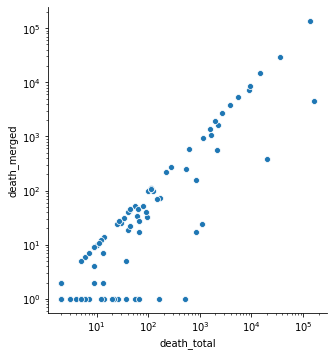

In [37]:
g = sns.relplot(x='death_total', y='death_merged', data=(df_country.dropna()+1))
g.set(yscale='log', xscale='log')
plt.show()

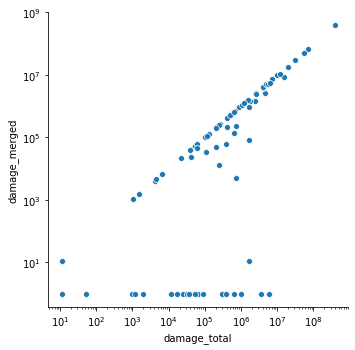

In [38]:
g = sns.relplot(x='damage_total', y='damage_merged', data=(df_country.dropna()+1))
g.set(yscale='log', xscale='log')
plt.show()

In [39]:
df_country.to_excel(project_dir.joinpath('data/country_merge_coverage.xlsx'))

#### Count country/years data points

In [40]:
df_merged.groupby(['ISO', 'year']).DisNo.count().describe()

count    817.000000
mean       1.815177
std        1.573794
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       13.000000
Name: DisNo, dtype: float64

In [41]:
df_merged[df_merged.is_match].groupby(['ISO', 'year']).DisNo.count().describe()

count    495.000000
mean       1.769697
std        1.281877
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        9.000000
Name: DisNo, dtype: float64

In [42]:
df_merged[df_merged.is_match].groupby(['ISO']).DisNo.count().describe()

count     70.000000
mean      12.514286
std       22.401956
min        1.000000
25%        2.000000
50%        4.000000
75%       10.500000
max      125.000000
Name: DisNo, dtype: float64

# All storm types

## Load data

In [43]:
project_dir = Path().resolve().parents[2]

In [44]:
df_tce = pd.read_csv(project_dir.joinpath('data/TCE-DAT_historic-exposure_1950-2015_cl_distances.csv'))
df_emdat = pd.read_excel(project_dir.joinpath('data/em_dat.xlsx'), header=6)
df_emdat.columns = df_emdat.columns.str.replace(' ', '')
df_emdat = df_emdat.rename(columns={'TotalDamages(\'000US$)': 'TotalDamages'})

In [45]:
df_tce.head()

,year,IBTrACS_ID,TC_name,NatCatSERVICE_ID,genesis_basin,countries_affected,ISO3,v_land_SI,v_land_kn,pop_34kn,...,pop_96kn_15km,assets_34kn_15km,assets_64kn_15km,assets_96kn_15km,pop_34kn_30km,pop_64kn_30km,pop_96kn_30km,assets_34kn_30km,assets_64kn_30km,assets_96kn_30km
0,1950,1950166N14262,UNNAMED,NaN,EP,single,MEX,47.3,92.0,1.435042e+06,...,0.000000,1.814476e+09,4.357072e+08,0.000000e+00,7.637151e+05,142266.342695,0.000000,2.760891e+09,5.392150e+08,0.000000e+00
1,1950,1950174N17126,ELSIE,NaN,WP,multi,JPN,51.7,100.6,8.460128e+06,...,19704.633461,5.334348e+10,7.370407e+09,2.335967e+08,8.230620e+06,777936.359565,19704.633461,6.854200e+10,7.370407e+09,2.335967e+08
2,1950,1950174N17126,ELSIE,NaN,WP,multi,KOR,19.5,37.8,4.054694e+05,...,0.000000,8.689325e+08,0.000000e+00,0.000000e+00,4.054694e+05,0.000000,0.000000,8.689325e+08,0.000000e+00,0.000000e+00
3,1950,1950185N18254,UNNAMED,NaN,EP,single,MEX,28.8,55.9,1.943859e+05,...,0.000000,4.938643e+08,0.000000e+00,0.000000e+00,1.681960e+05,0.000000,0.000000,6.512574e+08,0.000000e+00,0.000000e+00
4,1950,1950191N12149,UNNAMED,NaN,WP,single,JPN,26.0,50.5,1.495236e+05,...,0.000000,1.206838e+09,0.000000e+00,0.000000e+00,1.350129e+05,0.000000,0.000000,1.647435e+09,0.000000e+00,0.000000e+00


In [46]:
df_emdat = df_emdat[(df_emdat.Year >= 1980) & (df_emdat.DisasterType == 'Storm')]

In [47]:
df_emdat.count()

DisNo                           3541
Year                            3541
Seq                             3541
DisasterGroup                   3541
DisasterSubgroup                3541
DisasterType                    3541
DisasterSubtype                 2902
DisasterSubsubtype               950
EventName                       1912
EntryCriteria                   3541
Country                         3541
ISO                             3541
Region                          3541
Continent                       3541
Location                        3104
Origin                            35
AssociatedDis                   1158
AssociatedDis2                   417
OFDAResponse                     243
Appeal                           519
Declaration                      703
AidContribution                  136
DisMagValue                     1028
DisMagScale                     3541
Latitude                         112
Longitude                        113
LocalTime                          5
R

## Match TCE-DAT events to EM-DAT data when possible

In [48]:
# Register events start dates
df_tce['start_date'] = pd.to_datetime(df_tce.IBTrACS_ID.str.slice(0, 7), format='%Y%j')
df_tce['year'] = df_tce.start_date.dt.year
df_tce['month'] = df_tce.start_date.dt.month
df_tce['day'] = df_tce.start_date.dt.day
df_tce = df_tce.rename(columns={'ISO3': 'ISO'})

# todo: not drop all these events that do not have a start day ! we only need the year...
df_emdat = df_emdat.dropna(subset=['StartDay']).rename(columns={'StartYear':'year', 'StartMonth':'month', 'StartDay':'day'})
df_emdat['start_date'] = pd.to_datetime(df_emdat[['year', 'month', 'day']])

------
Test new code

-----


In [49]:
df_tce.start_date.min(), df_tce.start_date.max()

(Timestamp('1950-06-15 00:00:00'), Timestamp('2015-12-21 00:00:00'))

In [50]:
df_emdat.start_date.min(), df_emdat.start_date.max()

(Timestamp('1980-01-27 00:00:00'), Timestamp('2020-06-07 00:00:00'))

In [51]:
# Filter data to only keep years present in both datasets
df_tce = df_tce[df_tce.start_date.dt.year >= 1980]
df_emdat = df_emdat[df_emdat.start_date.dt.year <= 2015]
len(df_tce), len(df_emdat)

(3118, 2884)

In [52]:
len(df_emdat), df_emdat['EventName'].count()

(2884, 1595)

Most recent EM-DAT events have a name: we can try using it to match with IBTrACS

In [53]:
len(df_tce[(df_tce.TC_name!='UNNAMED')])

2576

In [54]:
# Merge on country, year, without looking at the event name. Duplicates will need to be filtered
df = df_emdat.merge(df_tce, on=['ISO', 'year'], suffixes=('', '_tce'))
df.EventName = df.EventName.astype('str') # remove NaN values
df[['ISO', 'year', 'EventName', 'TC_name']]

,ISO,year,EventName,TC_name
0,BRB,1980,Allen,ALLEN
1,CHN,1980,Joe,GEORGIA
2,CHN,1980,Joe,HERBERT
3,CHN,1980,Joe,UNNAMED
4,CHN,1980,Joe,UNNAMED
...,...,...,...,...
9126,VNM,2015,Tropical storm Kujira,VAMCO
9127,VNM,2015,Tropical storm Kujira,MUJIGAE
9128,VNM,2015,Cyclone Vamco,KUJIRA
9129,VNM,2015,Cyclone Vamco,VAMCO


In [55]:
# Filter rows where ibtracs name is in the em-dat event name: in addition to country/year matching, the names match too.
match = df.apply(lambda x: x.TC_name.casefold() in x.EventName.casefold(), axis=1)
df_merged_inner = df[match]
df_merged_inner.shape

(916, 78)

We are able to match around 900 events, but there might be some duplicates (country/years where multiple ibtracs TC names match the same EM-DAT event).

In [56]:
cols = [f'{exposed}_{v}kn' for exposed in ['pop', 'assets'] for v in [34, 64, 96]]
cols

['pop_34kn',
 'pop_64kn',
 'pop_96kn',
 'assets_34kn',
 'assets_64kn',
 'assets_96kn']

In [57]:
# Handle the duplicates:
#df_merged_inner.loc[df_merged_inner.DisNo.duplicated(keep=False), ['ISO', 'year', 'EventName', 'DisNo', 'TC_name', '34kn_pop']]
# Multiple TCE-DAT cyclones (with different DisNo) considered as a single event in EM-DAT, 
# so we add the indicators (pop/assets exposed) together
exposure_names = cols + [c + f'_{d}km' for c in cols for d in [5, 15, 30]]

# Ignore the warning as it works
pd.set_option('mode.chained_assignment',None)
is_dup = df_merged_inner.DisNo.duplicated(keep=False)
df_merged_inner.loc[is_dup, exposure_names] = df_merged_inner.loc[is_dup, ['DisNo']+exposure_names].copy().groupby('DisNo').transform('sum')
pd.set_option('mode.chained_assignment','warn')

df_merged_inner = df_merged_inner.drop_duplicates(subset='DisNo')

In [58]:
# Create exclusive bins (34kn - 64kn, 64kn - 96kn, 96+, instead of 34+, 64+, 96+)
for exposed in ['pop', 'assets']:
    df_merged_inner[f'{exposed}34'] = df_merged_inner[f'{exposed}_34kn'] - df_merged_inner[f'{exposed}_64kn']
    df_merged_inner[f'{exposed}64'] = df_merged_inner[f'{exposed}_64kn'] - df_merged_inner[f'{exposed}_96kn']
    df_merged_inner[f'{exposed}96'] = df_merged_inner[f'{exposed}_96kn']
    
    # Same for pop/assets below a certain distance from the coastline
    for d in [5, 15, 30]:
        df_merged_inner[f'{exposed}34_d{d}'] = df_merged_inner[f'{exposed}_34kn_{d}km'] - df_merged_inner[f'{exposed}_64kn_{d}km']
        df_merged_inner[f'{exposed}64_d{d}'] = df_merged_inner[f'{exposed}_64kn_{d}km'] - df_merged_inner[f'{exposed}_96kn_{d}km']
        df_merged_inner[f'{exposed}96_d{d}'] = df_merged_inner[f'{exposed}_96kn_{d}km']

In [59]:
df_merged_inner[['ISO', 'year', 'EventName', 'TC_name']]

,ISO,year,EventName,TC_name
0,BRB,1980,Allen,ALLEN
9,CUB,1980,Allen,ALLEN
11,DMA,1980,Allen,ALLEN
12,DOM,1980,Allen,ALLEN
14,GRD,1980,Allen,ALLEN
...,...,...,...,...
9120,VUT,2015,Cyclone 'Pam',PAM
9122,YEM,2015,Cyclone Megh,MEGH
9123,YEM,2015,Cyclone Chapala,CHAPALA
9125,VNM,2015,Tropical storm Kujira,KUJIRA


In [60]:
df_merged = df_emdat.merge(df_merged_inner, on=df_emdat.columns.tolist(), how='outer')
df_merged.head()

,DisNo,Year,Seq,DisasterGroup,DisasterSubgroup,DisasterType,DisasterSubtype,DisasterSubsubtype,EventName,EntryCriteria,...,assets96,assets34_d5,assets64_d5,assets96_d5,assets34_d15,assets64_d15,assets96_d15,assets34_d30,assets64_d30,assets96_d30
0,1980-0054-BRA,1980,54,Natural,Meteorological,Storm,Convective storm,Tornado,NaN,Kill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1980-0306-BRB,1980,306,Natural,Meteorological,Storm,Tropical cyclone,NaN,Allen,Affect,...,2.317466e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1980-0069-CHN,1980,69,Natural,Meteorological,Storm,Tropical cyclone,NaN,Joe,Kill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1980-0229-CUB,1980,229,Natural,Meteorological,Storm,Tropical cyclone,NaN,Allen,Declar,...,1.397305e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1980-0230-DMA,1980,230,Natural,Meteorological,Storm,Tropical cyclone,NaN,Allen,Declar,...,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
df_merged.loc[df_merged.v_land_kn.isna(), ['DisNo', 'ISO', 'year', 'EventName', 'TC_name', 
                                           'TotalDeaths', 'TotalAffected', 'TotalDamages']].describe()

,year,TotalDeaths,TotalAffected,TotalDamages
count,1988.000000,1393.000000,1.216000e+03,9.410000e+02
mean,1999.626258,156.270639,3.351102e+05,4.071732e+05
std,9.584926,3752.276429,3.217953e+06,9.935655e+05
min,1980.000000,1.000000,1.000000e+00,5.000000e+00
25%,1992.000000,4.000000,2.775000e+02,7.500000e+03
50%,2000.000000,11.000000,2.400000e+03,7.200000e+04
75%,2007.000000,27.000000,3.000000e+04,3.360000e+05
max,2015.000000,138866.000000,1.000000e+08,1.400000e+07


In [62]:
df_merged.loc[~df_merged.v_land_kn.isna(), ['DisNo', 'ISO', 'year', 'EventName', 'TC_name', 
                                            'TotalDeaths', 'TotalAffected', 'TotalDamages']].describe()

,year,TotalDeaths,TotalAffected,TotalDamages
count,896.000000,729.000000,7.130000e+02,6.200000e+02
mean,2001.323661,308.246914,6.902823e+05,1.021790e+06
std,9.374763,5169.252462,2.245217e+06,5.881499e+06
min,1980.000000,1.000000,1.000000e+00,1.000000e+01
25%,1994.750000,4.000000,2.500000e+03,1.688550e+04
50%,2003.000000,13.000000,2.580000e+04,8.270000e+04
75%,2009.000000,46.000000,2.600490e+05,4.272300e+05
max,2015.000000,138366.000000,2.962200e+07,1.250000e+08


In [63]:
df_merged['is_match'] = ~df_merged.v_land_kn.isna()

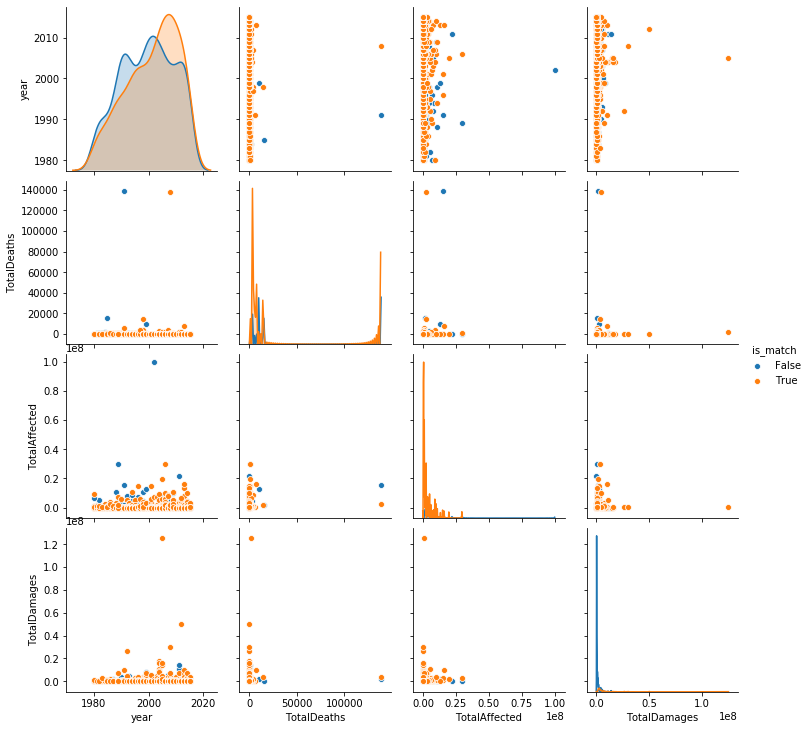

In [64]:
sns.pairplot(df_merged[['is_match', 'ISO', 'year', 'EventName', 'TC_name', 'TotalDeaths', 'TotalAffected', 'TotalDamages']], hue='is_match')

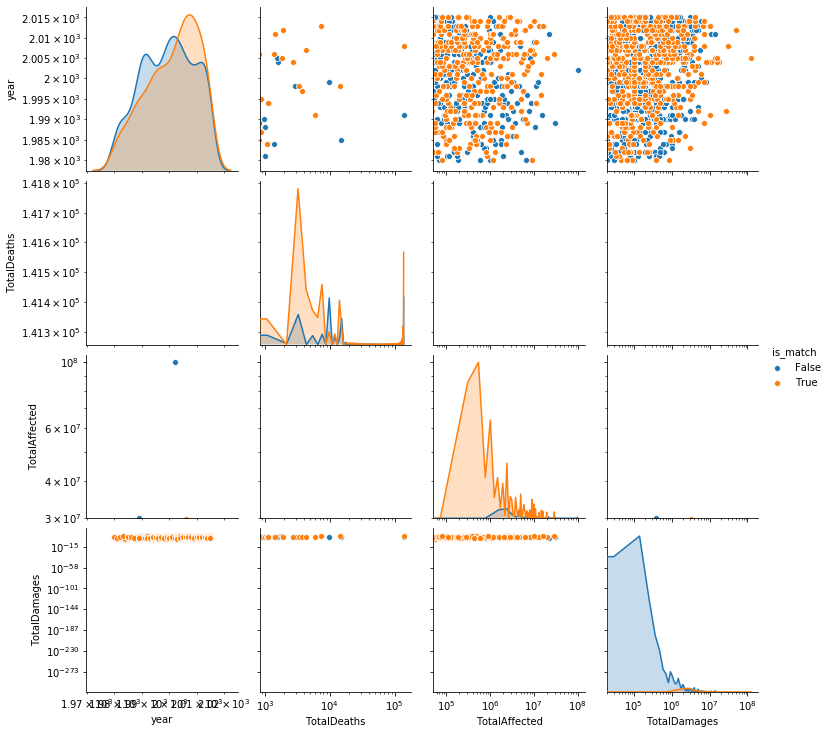

In [65]:
g = sns.pairplot(df_merged[['is_match', 'ISO', 'year', 'EventName', 'TC_name', 'TotalDeaths', 'TotalAffected', 'TotalDamages']], hue='is_match')
g.set(yscale='log')
g.set(xscale='log')
plt.show()

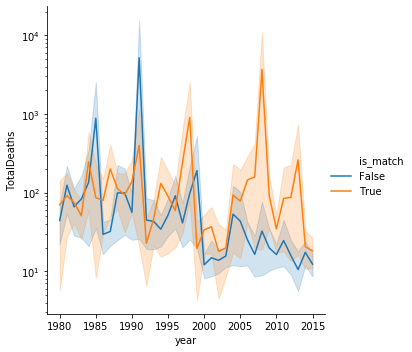

In [66]:
g = sns.relplot(x='year', y='TotalDeaths', hue='is_match', kind='line', data=df_merged)
g.set(yscale='log')
plt.show()

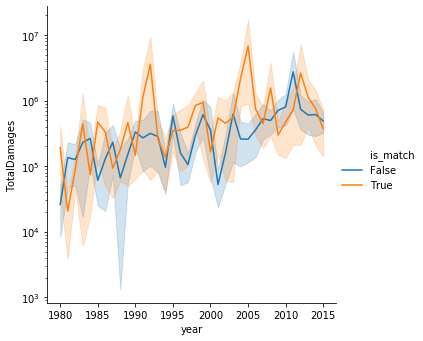

In [67]:
g = sns.relplot(x='year', y='TotalDamages', hue='is_match', kind='line', data=df_merged)
g.set(yscale='log')
plt.show()

In [68]:
df_merged.to_excel(project_dir.joinpath('data/emdat_tcedat_merged_all_storm_types.xlsx'), index=False)

In [69]:
df_merged.is_match.value_counts()

False    1988
True      896
Name: is_match, dtype: int64

In [70]:
# Quality check the merging, to see what countries should be kept
df_country = df_merged.groupby('ISO').TotalDeaths.sum()
df_country = pd.concat([df_merged.groupby('ISO').TotalDeaths.sum(),
                        df_merged[df_merged.is_match].groupby('ISO').TotalDeaths.sum(),
                        df_merged.groupby('ISO').TotalDamages.sum(),
                        df_merged[df_merged.is_match].groupby('ISO').TotalDamages.sum(),
                        df_merged.groupby('ISO').DisNo.count(),
                        df_merged[df_merged.is_match].groupby('ISO').DisNo.count(),
                       ], axis=1, keys=['death_total', 'death_merged', 'damage_total', 'damage_merged', 'total_events', 'merged_events']
                      ).fillna(0).astype('int')
df_country['death_share_merged'] = df_country.death_merged / df_country.death_total
df_country['damage_share_merged'] = df_country.damage_merged / df_country.damage_total
df_country['share_events_merged'] = df_country.merged_events / df_country.total_events

In [71]:
df_country

,death_total,death_merged,damage_total,damage_merged,total_events,merged_events,death_share_merged,damage_share_merged,share_events_merged
AFG,123,0,0,0,4,0,0.000000,NaN,0.000000
AIA,0,0,2325,2165,3,2,NaN,0.931183,0.666667
ALB,8,0,0,0,2,0,0.000000,NaN,0.000000
ANT,13,13,1050000,1050000,2,2,1.000000,1.000000,1.000000
ARG,109,0,96200,0,14,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
WLF,1,0,0,0,2,0,0.000000,NaN,0.000000
WSM,43,21,626500,133000,6,2,0.488372,0.212291,0.333333
YEM,56,26,200000,200000,4,2,0.464286,1.000000,0.500000
ZAF,238,0,714041,0,22,0,0.000000,0.000000,0.000000


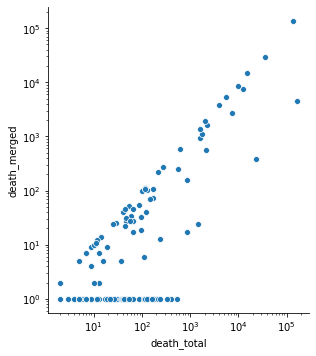

In [72]:
g = sns.relplot(x='death_total', y='death_merged', data=(df_country.dropna()+1))
g.set(yscale='log', xscale='log')
plt.show()

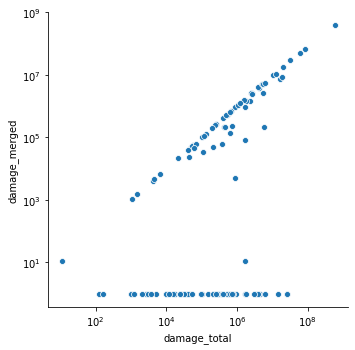

In [73]:
g = sns.relplot(x='damage_total', y='damage_merged', data=(df_country.dropna()+1))
g.set(yscale='log', xscale='log')
plt.show()

In [74]:
df_country.to_excel(project_dir.joinpath('data/country_merge_coverage_all_storm_types.xlsx'))

In [75]:
df_merged.groupby(['ISO', 'year']).DisNo.count().describe()

count    1337.000000
mean        2.157068
std         2.646461
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        26.000000
Name: DisNo, dtype: float64

In [76]:
df_merged[df_merged.is_match].groupby(['ISO', 'year']).DisNo.count().describe()

count    499.000000
mean       1.795591
std        1.296543
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        9.000000
Name: DisNo, dtype: float64

In [77]:
df_merged[df_merged.is_match].groupby(['ISO']).DisNo.count().describe()

count     71.000000
mean      12.619718
std       22.933672
min        1.000000
25%        2.000000
50%        4.000000
75%       10.000000
max      130.000000
Name: DisNo, dtype: float64

## Look at IBTrACS unmerged data

In [78]:
# storms/country events
len(df_merged[df_merged.is_match].IBTrACS_ID), len(df_tce.IBTrACS_ID), len(df_merged[df_merged.is_match].IBTrACS_ID)/len(df_tce.IBTrACS_ID)

(896, 3118, 0.2873636946760744)

In [79]:
# storms events (across multiple countries)
(len(df_merged[df_merged.is_match].IBTrACS_ID.unique()), len(df_tce.IBTrACS_ID.unique()), 
 len(df_merged[df_merged.is_match].IBTrACS_ID.unique())/len(df_tce.IBTrACS_ID.unique()))

(570, 1669, 0.341521869382864)

In [80]:
df_tce.count()

year                  3118
IBTrACS_ID            3118
TC_name               3118
NatCatSERVICE_ID      2202
genesis_basin         2365
countries_affected    3118
ISO                   3118
v_land_SI             3118
v_land_kn             3118
pop_34kn              3118
pop_64kn              3118
pop_96kn              3118
assets_34kn           3118
assets_64kn           3118
assets_96kn           3118
pop_34kn_5km          1596
pop_64kn_5km          1596
pop_96kn_5km          1596
assets_34kn_5km       1596
assets_64kn_5km       1596
assets_96kn_5km       1596
pop_34kn_15km         1596
pop_64kn_15km         1596
pop_96kn_15km         1596
assets_34kn_15km      1596
assets_64kn_15km      1596
assets_96kn_15km      1596
pop_34kn_30km         1596
pop_64kn_30km         1596
pop_96kn_30km         1596
assets_34kn_30km      1596
assets_64kn_30km      1596
assets_96kn_30km      1596
start_date            3118
month                 3118
day                   3118
dtype: int64

In [81]:
#df_tce['is_match'] = False
df_tce.merge(df_merged.loc[df_merged.is_match, ['IBTrACS_ID', 'ISO', 'is_match']], on=['IBTrACS_ID', 'ISO']).count()

year                  896
IBTrACS_ID            896
TC_name               896
NatCatSERVICE_ID      818
genesis_basin         628
countries_affected    896
ISO                   896
v_land_SI             896
v_land_kn             896
pop_34kn              896
pop_64kn              896
pop_96kn              896
assets_34kn           896
assets_64kn           896
assets_96kn           896
pop_34kn_5km          545
pop_64kn_5km          545
pop_96kn_5km          545
assets_34kn_5km       545
assets_64kn_5km       545
assets_96kn_5km       545
pop_34kn_15km         545
pop_64kn_15km         545
pop_96kn_15km         545
assets_34kn_15km      545
assets_64kn_15km      545
assets_96kn_15km      545
pop_34kn_30km         545
pop_64kn_30km         545
pop_96kn_30km         545
assets_34kn_30km      545
assets_64kn_30km      545
assets_96kn_30km      545
start_date            896
month                 896
day                   896
is_match              896
dtype: int64

In [82]:
df_tce_analysis = df_tce.merge(df_merged.loc[df_merged.is_match, ['IBTrACS_ID', 'ISO', 'is_match']], on=['IBTrACS_ID', 'ISO'], how='left')
df_tce_analysis.is_match.fillna(False, inplace=True)
df_tce_analysis.to_excel(project_dir.joinpath('data/emdat_tcedat_right_join.xlsx'))
df_tce_analysis

,year,IBTrACS_ID,TC_name,NatCatSERVICE_ID,genesis_basin,countries_affected,ISO,v_land_SI,v_land_kn,pop_34kn,...,pop_34kn_30km,pop_64kn_30km,pop_96kn_30km,assets_34kn_30km,assets_64kn_30km,assets_96kn_30km,start_date,month,day,is_match
0,1980,1980001S13173,PENI,NaN,SP,single,FJI,43.5,84.5,4.510292e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,1980-01-01,1,1,False
1,1980,1980003S15137,PAUL,MR198001B002,SP,single,AUS,51.8,100.7,2.927805e+05,...,2.213148e+05,1.509321e+05,0.000000e+00,1.048263e+10,6.042915e+09,0.000000e+00,1980-01-03,1,3,False
2,1980,1980033S12161,UNNAMED,NaN,SP,multi,SLB,25.2,49.0,1.150481e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,1980-02-02,2,2,False
3,1980,1980068S13068,LAURE,MR198003B021,SI,single,MUS,49.3,95.9,9.367037e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,1980-03-08,3,8,False
4,1980,1980069S12161,SINA,NaN,SP,multi,NCL,21.7,42.2,5.908023e+04,...,NaN,NaN,NaN,NaN,NaN,NaN,1980-03-09,3,9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3114,2015,2015309N14067,MEGH,NaN,NI,multi,SOM,39.0,75.8,2.266291e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-05,11,5,True
3115,2015,2015309N14067,MEGH,NaN,NI,multi,YEM,61.6,119.7,5.999349e+04,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-05,11,5,True
3116,2015,2015312N11083,UNNAMED,NaN,NI,single,IND,19.4,37.8,8.469681e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-08,11,8,False
3117,2015,2015344N07145,MELOR,NaN,WP,multi,PHL,65.9,128.1,5.133590e+07,...,4.507621e+07,1.688196e+07,4.606214e+06,3.868367e+11,1.640968e+11,4.592332e+10,2015-12-10,12,10,True


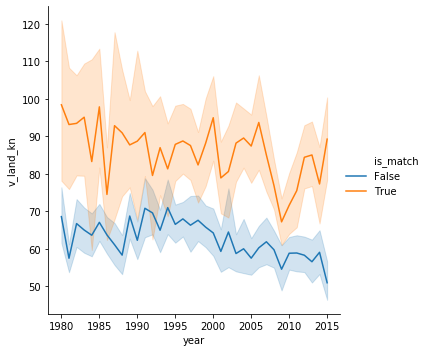

In [83]:
sns.relplot(x='year', y='v_land_kn', hue='is_match', kind='line', data=df_tce_analysis)

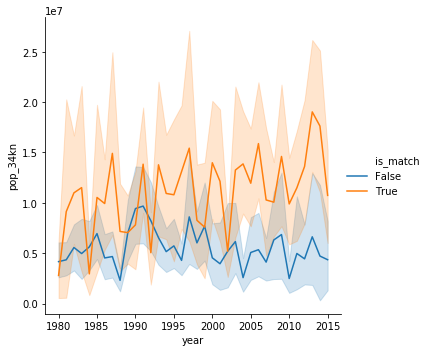

In [84]:
sns.relplot(x='year', y='pop_34kn', hue='is_match', kind='line', data=df_tce_analysis)

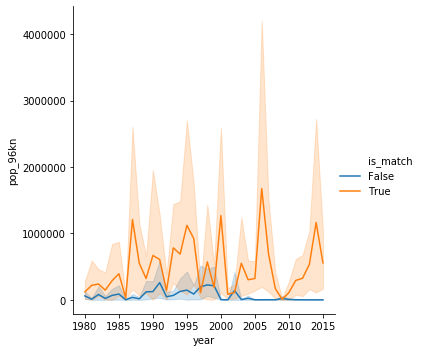

In [85]:
sns.relplot(x='year', y='pop_96kn', hue='is_match', kind='line', data=df_tce_analysis)

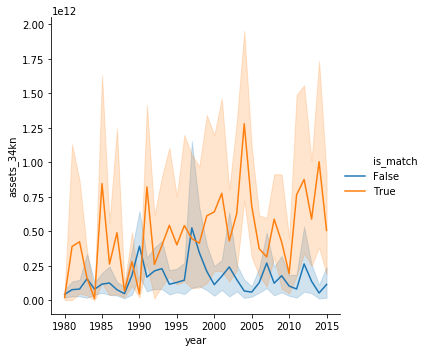

In [86]:
sns.relplot(x='year', y='assets_34kn', hue='is_match', kind='line', data=df_tce_analysis)

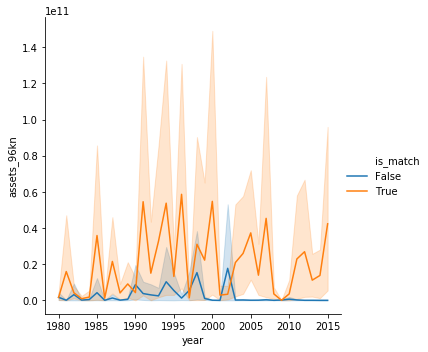

In [87]:
sns.relplot(x='year', y='assets_96kn', hue='is_match', kind='line', data=df_tce_analysis)

In [88]:
df_tce_analysis.groupby('is_match')[['v_land_kn']].describe()

v_land_kn                                                           
             count       mean        std   min     25%    50%      75%    max
is_match                                                                     
False       2223.0  63.238776  23.877035  34.0  44.200  56.90   76.500  163.4
True         896.0  84.612723  29.755480  34.6  59.025  83.25  107.675  171.8

In [89]:
df_tce_analysis[df_tce_analysis.ISO.isin(['JPN', 'CHN', 'USA', 'KOR', 'AUS', 'CAN', 'MEX', 'NZL', 'PHL'])
               ].groupby(['ISO', 'is_match'])[['v_land_kn']].describe()

v_land_kn                                                       \
                 count       mean        std   min     25%     50%      75%   
ISO is_match                                                                  
AUS False        164.0  71.381707  27.766138  36.9  49.550   64.25   82.500   
    True          16.0  99.675000  29.623673  47.1  78.450  103.25  121.525   
CAN False         47.0  66.568085  21.354911  34.4  49.950   68.50   78.600   
    True           7.0  88.042857  14.773947  65.4  80.000   86.50   96.950   
CHN False        188.0  65.399468  21.127463  34.0  46.900   65.55   81.450   
    True         100.0  81.013000  23.726091  34.6  65.350   77.35   94.450   
JPN False        178.0  78.817978  26.990021  34.1  53.525   77.60   99.150   
    True          65.0  97.743077  23.889655  44.6  81.700  103.80  115.900   
KOR False         29.0  58.393103  17.144698  36.7  47.900   54.30   67.500   
    True          15.0  81.686667  23.068775  48.4  62.300   79.00   99.500   
MEX False        111.0  57.863063  21.470148  34.5  41.000   52.00   68.350   
    True          63.0  77.663492  31.326117  35.8  53.400   72.50   97.850   
NZL False          1.0  86.300000        NaN  86.3  86.300   86.30   86.300   
    True           2.0  86.250000  20.011122  72.1  79.175   86.25   93.325   
PHL False        152.0  70.629605  28.877466  34.5  49.275   61.65   88.400   
    True         130.0  95.317692  35.455712  38.1  60.250   99.45  124.950   
USA False         67.0  56.550746  15.568562  36.5  41.200   55.90   66.950   
    True          57.0  88.503509  28.471470  37.7  62.700   86.80  109.900   

                     
                max  
ISO is_match         
AUS False     163.4  
    True      138.7  
CAN False     115.7  
    True      110.5  
CHN False     121.8  
    True      138.3  
JPN False     139.7  
    True      136.6  
KOR False     102.6  
    True      121.5  
MEX False     133.7  
    True      159.1  
NZL False      86.3  
    True      100.4  
PHL False     150.9  
    True      171.8  
USA False      91.4  
    True      136.9

In [90]:
d = df_tce_analysis.groupby('is_match')[cols].sum()
d

,pop_34kn,pop_64kn,pop_96kn,assets_34kn,assets_64kn,assets_96kn
is_match,,,,,,
False,1.245894e+10,1.767510e+09,1.479707e+08,3.552809e+14,7.125207e+13,5.580768e+12
True,1.044416e+10,2.818320e+09,4.386344e+08,4.901229e+14,1.476148e+14,1.884455e+13


In [91]:
# share of exposure matched with EM-DAT
d.iloc[1] / (d.iloc[0] + d.iloc[1])

pop_34kn       0.456015
pop_64kn       0.614571
pop_96kn       0.747751
assets_34kn    0.579750
assets_64kn    0.674450
assets_96kn    0.771517
dtype: float64

In [92]:
d = df_tce_analysis[df_tce_analysis.ISO.isin(['JPN', 'CHN', 'USA', 'KOR', 'AUS', 'CAN', 'MEX', 'NZL', 'PHL'])
                   ].groupby(['ISO', 'is_match'])[cols].sum()
d

pop_34kn      pop_64kn      pop_96kn   assets_34kn  \
ISO is_match                                                           
AUS False     1.152495e+07  8.136987e+05  6.764195e+04  8.335365e+11   
    True      2.441008e+06  8.082313e+05  1.812339e+05  2.379616e+11   
CAN False     4.618216e+07  1.453293e+07  5.051289e+05  5.680517e+12   
    True      2.122244e+07  3.144321e+06  1.355180e+05  2.429867e+12   
CHN False     3.049704e+09  4.050763e+08  1.310180e+07  2.083735e+13   
    True      3.105397e+09  6.601081e+08  6.990489e+07  3.674653e+13   
JPN False     1.725448e+09  4.054105e+08  3.273124e+07  1.630139e+14   
    True      1.743880e+09  5.917914e+08  5.901862e+07  1.830238e+14   
KOR False     2.167745e+08  5.438439e+07  5.551217e+05  1.362728e+13   
    True      2.287943e+08  5.113599e+07  7.416665e+06  1.945124e+13   
MEX False     1.644977e+08  1.349621e+07  3.910195e+05  2.036841e+12   
    True      2.254593e+08  3.187375e+07  5.474220e+06  3.149577e+12   
NZL False     8.478762e+05  1.321740e+04  0.000000e+00  6.205658e+10   
    True      1.356124e+06  4.438545e+05  4.954516e+03  1.604902e+11   
PHL False     1.167737e+09  2.336215e+08  3.155078e+07  7.982327e+12   
    True      1.914764e+09  6.578533e+08  1.892007e+08  1.451828e+13   
USA False     2.047325e+08  1.371703e+07  0.000000e+00  3.464800e+13   
    True      6.293436e+08  1.520093e+08  1.791789e+07  1.046402e+14   

               assets_64kn   assets_96kn  
ISO is_match                              
AUS False     5.862095e+10  5.288745e+09  
    True      7.270082e+10  1.885614e+10  
CAN False     1.786342e+12  5.363905e+10  
    True      3.457039e+11  9.881922e+09  
CHN False     2.789368e+12  7.146348e+10  
    True      7.422947e+12  7.750282e+11  
JPN False     3.893638e+13  3.509985e+12  
    True      6.072534e+13  6.377012e+12  
KOR False     3.405152e+12  6.020760e+10  
    True      4.556389e+12  5.720965e+11  
MEX False     1.680744e+11  4.525423e+09  
    True      4.424139e+11  6.786016e+10  
NZL False     2.215335e+09  0.000000e+00  
    True      3.898490e+10  8.870182e+08  
PHL False     1.641202e+12  2.401135e+11  
    True      5.003184e+12  1.471826e+12  
USA False     2.246941e+12  0.000000e+00  
    True      2.450296e+13  2.754150e+12

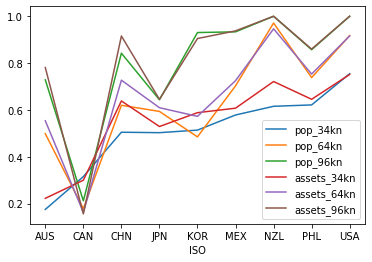

In [93]:
# share of exposure matched with EM-DAT
(d.reset_index()[d.reset_index().is_match].drop(columns='is_match').groupby(['ISO']).sum() / d.groupby(['ISO']).sum()).plot()

In [94]:
(d.reset_index()[d.reset_index().is_match].drop(columns='is_match').groupby(['ISO']).sum() / d.groupby(['ISO']).sum())

,pop_34kn,pop_64kn,pop_96kn,assets_34kn,assets_64kn,assets_96kn
ISO,,,,,,
AUS,0.174783,0.498315,0.728210,0.222083,0.553608,0.780958
CAN,0.314852,0.177874,0.211533,0.299600,0.162147,0.155569
CHN,0.504524,0.619713,0.842160,0.638139,0.726862,0.915577
JPN,0.502656,0.593452,0.643256,0.528913,0.609315,0.644990
KOR,0.513488,0.484608,0.930364,0.588032,0.572300,0.904781
MEX,0.578165,0.702530,0.933333,0.607274,0.724689,0.937482
NZL,0.615301,0.971082,1.000000,0.721153,0.946230,1.000000
PHL,0.621172,0.737938,0.857076,0.645239,0.752994,0.859742
USA,0.754540,0.917231,1.000000,0.751250,0.916002,1.000000


Let's have a look at a few examples of no-match, among the larger exposed assets/pop:
- CAN
    - EARL, 2010, high number of 96 assets/pop, probably overestimated by TCE-DAT model? In reality, category 1 storm, power losses, 1 person drowned and unknown damage
    - NOEL, 2010, only 1 fatality
    - IKE, 2008, high number of 34 assets/pop, no fatalities and known damage either
- PHL
    - SIBYL 1995, actually in EM-DAT, but mismatch because of a typo
    - UNNAMED 1998, probably typhoon Zeb, present in EM-DAT
    - YUNYA 1991, actually recorded in EM-DAT under Volcanic activity, as most of the casualties came from heavy rains mixing with volcanic ashes (and only 6 direct deaths)
- JPN
    - VICKI 1998, recorded as a duplicate in EM-DAT (with WALDO 1998), so it is actually a match
    - HIGOS 2002, 5 deaths and 2b dollar damage, but does not seem to appear in EM-DAT
    - RYAN 1995, 5 deaths, not much data on wikipedia, does not seem to be in EM-DAT
    - UNNAMED 1990, actually recorded in EM-DAT (typhoon FLO)
    - OPAL 1997, 3 people killed, not recorded in EM-DAT

**Look at the results with exclusive bins (34 < v < 64 e.g.)**

Not much difference ?

In [95]:
df_tce_analysis = df_tce.merge(df_merged.loc[df_merged.is_match, ['IBTrACS_ID', 'ISO', 'is_match']], on=['IBTrACS_ID', 'ISO'], how='left')
# exclusive bins
df_tce_analysis['pop_34kn'] -= df_tce_analysis['pop_64kn']
df_tce_analysis['pop_64kn'] -= df_tce_analysis['pop_96kn']
df_tce_analysis['assets_34kn'] -= df_tce_analysis['assets_64kn']
df_tce_analysis['assets_64kn'] -= df_tce_analysis['assets_96kn']

df_tce_analysis.is_match.fillna(False, inplace=True)

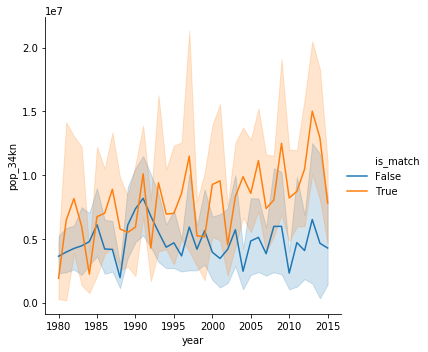

In [96]:
sns.relplot(x='year', y='pop_34kn', hue='is_match', kind='line', data=df_tce_analysis)

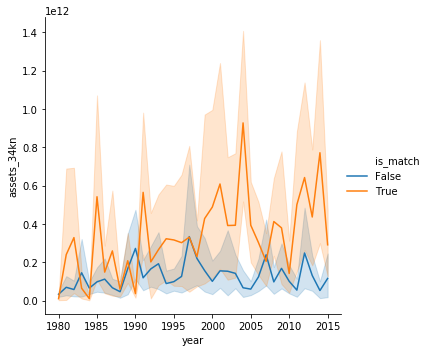

In [97]:
sns.relplot(x='year', y='assets_34kn', hue='is_match', kind='line', data=df_tce_analysis)

In [98]:
d = df_tce_analysis[df_tce_analysis.ISO.isin(['JPN', 'CHN', 'USA', 'KOR', 'AUS', 'CAN', 'MEX', 'NZL', 'PHL'])
                   ].groupby(['ISO', 'is_match'])[cols].sum()

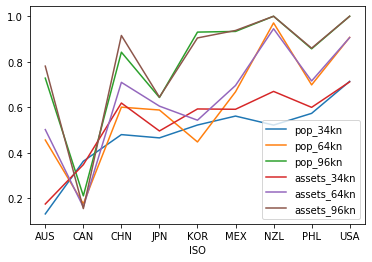

In [99]:
# share of exposure matched with EM-DAT
(d.reset_index()[d.reset_index().is_match].drop(columns='is_match').groupby(['ISO']).sum() / d.groupby(['ISO']).sum()).plot()

In [100]:
(d.reset_index()[d.reset_index().is_match].drop(columns='is_match').groupby(['ISO']).sum() / d.groupby(['ISO']).sum())

,pop_34kn,pop_64kn,pop_96kn,assets_34kn,assets_64kn,assets_96kn
ISO,,,,,,
AUS,0.132273,0.456644,0.728210,0.175776,0.502391,0.780958
CAN,0.363545,0.176608,0.211533,0.348619,0.162349,0.155569
CHN,0.480418,0.600913,0.842160,0.619012,0.709806,0.915577
JPN,0.466031,0.588405,0.643256,0.496390,0.605386,0.644990
KOR,0.522450,0.448180,0.930364,0.593019,0.543616,0.904781
MEX,0.561790,0.668263,0.933333,0.591609,0.696064,0.937482
NZL,0.522213,0.970766,1.000000,0.670017,0.945047,1.000000
PHL,0.573663,0.698727,0.857076,0.600086,0.715944,0.859742
USA,0.714198,0.907197,1.000000,0.712089,0.906361,1.000000
